# Generative modeling for two line fits with JAX

Here we will learn on how to use JAX to perform gradient descent to fit two line from datapoints that were generated by two separate processes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

In [2]:
def generate_data(n_points=[50,50], par1 = [1,1], par2 = [1,1], noise= 50):
    x1=(np.arange(n_points[0])*par1[0]).astype(int)
    y1=(np.arange(n_points[0])*par1[1]).astype(int)
    x2=(np.arange(n_points[1])*par2[1]).astype(int)
    y2=(np.arange(n_points[1])*par2[0]).astype(int)

    x1=x1+np.random.randint(0,noise,len(x1))
    y1=y1+np.random.randint(0,noise,len(x1))
    
    x2=x2+np.random.randint(0,noise,len(x2))
    y2=y2+np.random.randint(0,noise,len(x2))

    xy=np.hstack([np.vstack([x1,y1]),np.vstack([x2,y2])]).T

    group=np.concatenate([np.zeros(n_points[0]),np.ones(n_points[0])])
    
    return x1,x2,y1,y2, xy, group

In [3]:
np.random.seed(42)
x1,x2,y1,y2, xy,group =generate_data(n_points=[50,50], par1 = [20,1], par2 = [10,10], noise= 100)

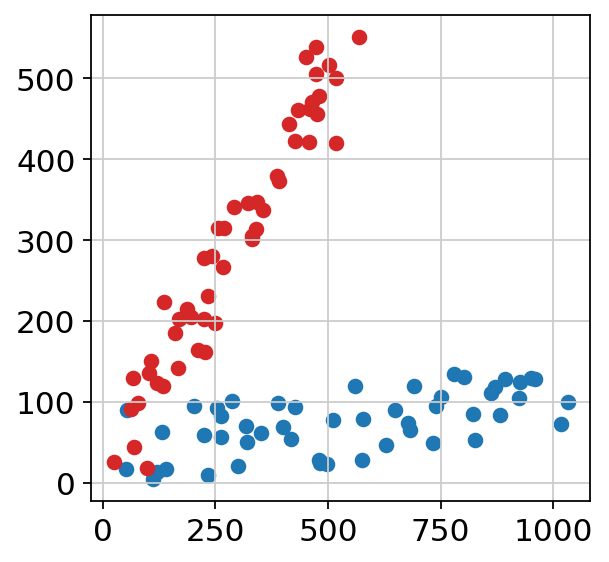

In [4]:
sc.set_figure_params()
plt.scatter(x1,y1,c="tab:blue")
plt.scatter(x2,y2,c="tab:red")

In [5]:
import jax
import jax.numpy as jnp
@jax.jit
def loss_fun(slopes):
    tr = jnp.dot(xy[:,0], slopes[0])
    loss1 = (tr - xy[:,1])**2

    tr = jnp.dot(xy[:,1], slopes[1])
    loss2 = (tr - xy[:,0])**2

    r1 = jnp.exp(-jnp.where(loss1>60,60,loss1)/.1)
    r2 = jnp.exp(-jnp.where(loss2>60,60,loss2)/.1)
    
    stacked_r = jnp.stack([r1,r2], axis=-1)
    return -jnp.log(r1+r2).sum()

## Initialisation of Slope Parameters

A proper strategy for good initial parameters is to obtain the slope of a single linear fit using least-squares method, and assign that slope to both lines to be fitted:

In [6]:
xy=xy/xy.max(axis=0) # let's noramlize between 0 and 1

a, _, _, _ = np.linalg.lstsq(xy[:,0].reshape(-1,1), xy[:,1].reshape(-1,1),rcond=None)
slopes = [a.ravel()[0],1/a.ravel()[0]]

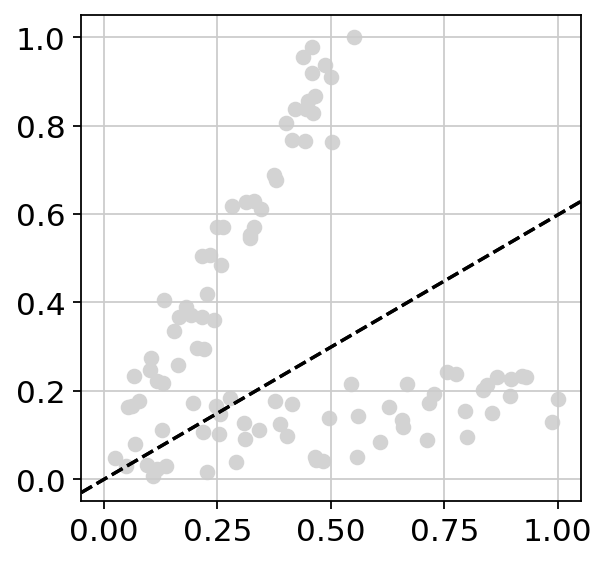

In [7]:
plt.scatter(xy[:,0],xy[:,1],c="lightgrey")
sl1 = slopes[0]
sl2 = np.inf if slopes[1]==0 else 1/slopes[1]
line1 = plt.axline([0, 0], slope=sl1, c="k", linestyle="--", zorder=99999)
line2 = plt.axline([0, 0], slope=sl2, c="k", linestyle="--", zorder=99999)

## JAX-Based Optimization Loop for Parameter Tuning 

In [8]:
import optax
optimizer=optax.adam(1e-2)

In [9]:
with jax.default_device(jax.devices("cpu")[0]):
    # initialize Adam with our slope parameters to track
    opt_state = optimizer.init(slopes)
    all_slopes=[]
    all_slopes.append(slopes)
    objs=[]
    for epoch in range(200):
        # calculate current loss and related gradients
        obj, grads = jax.value_and_grad(loss_fun)(slopes)
        # takes in the current optimizer state and gradients and 
        # returns the updates that need to be applied to the parameters
        updates, opt_state = optimizer.update(grads, opt_state)
        # applies the updates from the gradient transforms to the current parameters to return new ones
        slopes = optax.apply_updates(slopes, updates)
        # saving slope params and loss output for current iteration
        all_slopes.append(slopes)
        objs.append(obj)
        if ((epoch+1) % 20 == 0):
            print(f'Epoch {epoch+1}, Objective: {obj.item()}')

Epoch 20, Objective: 76.35686492919922
Epoch 40, Objective: 54.75714874267578
Epoch 60, Objective: 4.6016950607299805
Epoch 80, Objective: -16.003925323486328
Epoch 100, Objective: -20.09132194519043
Epoch 120, Objective: -20.415151596069336
Epoch 140, Objective: -20.41216278076172
Epoch 160, Objective: -20.415159225463867
Epoch 180, Objective: -20.41604995727539
Epoch 200, Objective: -20.416061401367188


### Loss function

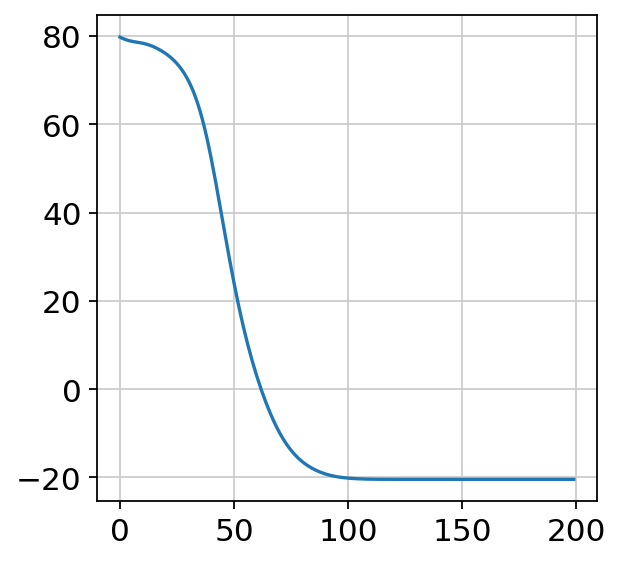

In [10]:
plt.plot(objs)

It seems we have converged after 100 iterations, let's look at the learned linear fits:

In [11]:
slopes

[Array(0.25233585, dtype=float32), Array(0.53707105, dtype=float32)]

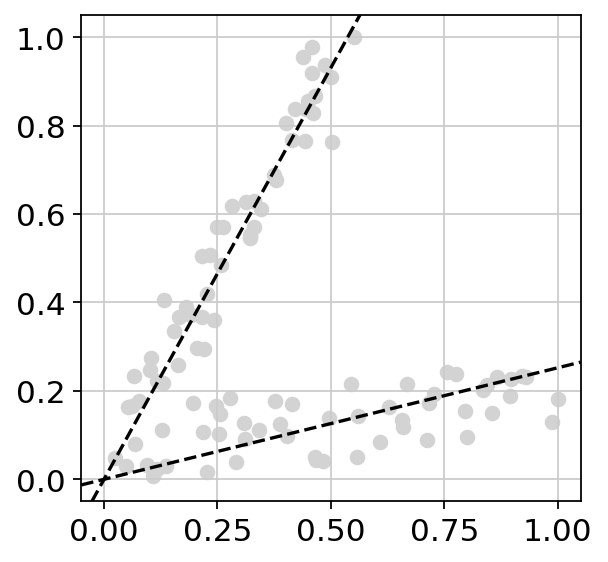

In [12]:
sc.set_figure_params()
plt.scatter(xy[:,0],xy[:,1],c="lightgrey")
plt.axline([0,0],slope=slopes[0],c="k",linestyle="--",zorder=99999)
plt.axline([0,0],slope=1/slopes[1],c="k",linestyle="--",zorder=99999)

The model seems to work well, we captured both processes!

### Visualising the learning of parameters

It is quite educative to show the actual updates of the slope parameters as the gradient descent occurs, here is an animation showing also the probability assignment of each point to one line or the other (color gradient).

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import matplotlib
from matplotlib.colors import Normalize

def get_assignment(xy, slopes):
    tr = np.dot(xy[:, 0], slopes[0])
    loss1 = (tr - xy[:, 1])**2
    tr = np.dot(xy[:, 1], slopes[1])
    loss2 = (tr - xy[:, 0])**2
    sresid = np.exp(-(loss1 - loss2) / .1)
    return sresid / (1 + sresid)

def generate_gif(xy, all_slopes):
    # Set up the initial plot
    fig, ax = plt.subplots()

    # Initialize colormap and normalization
    cmap = matplotlib.colormaps["bwr"]
    norm = Normalize(vmin=0, vmax=1)

    # Initial scatter plot
    sc = ax.scatter(xy[:, 0], xy[:, 1], facecolors=cmap(norm(get_assignment(xy, all_slopes[0]))), 
                    edgecolors='k',linewidth=.5,s=50)

    # Initial axlines
    sl1 = all_slopes[0][0]
    sl2 = np.inf if all_slopes[0][1] == 0 else 1 / all_slopes[0][1]
    line1, = ax.plot([], [], 'k--', zorder=99999)
    line2, = ax.plot([], [], 'k--', zorder=99999)

    # Update function
    def update(frame):
        # Remove previous lines
        line1.set_data([], [])
        line2.set_data([], [])

        # Update scatter plot colors
        sc.set_facecolors(cmap(norm(get_assignment(xy, all_slopes[frame]))))

        # Add new lines with updated slopes
        sl1 = all_slopes[frame][0]
        sl2 = np.inf if all_slopes[frame][1] == 0 else 1 / all_slopes[frame][1]
        x1 = np.array([-10, 10])
        y1 = sl1 * x1
        x2 = np.array([-10, 10])
        y2 = sl2 * x2
        line1.set_data(x1, y1)
        line2.set_data(x2, y2)
        return sc, line1, line2

    # Create the animation
    ani = animation.FuncAnimation(fig, update, 
                                  frames=np.concatenate([np.zeros(30,dtype=int),np.arange(len(all_slopes))]), 
                                                               blit=True, repeat=True)

    # To save the animation using Pillow as a gif
    writer = animation.PillowWriter(fps=30,
                                     metadata=dict(artist='Me'),
                                     bitrate=1800)
    ani.save('optim.gif', writer=writer)

    # plt.show()
    plt.close()


In [14]:
generate_gif(xy, all_slopes)

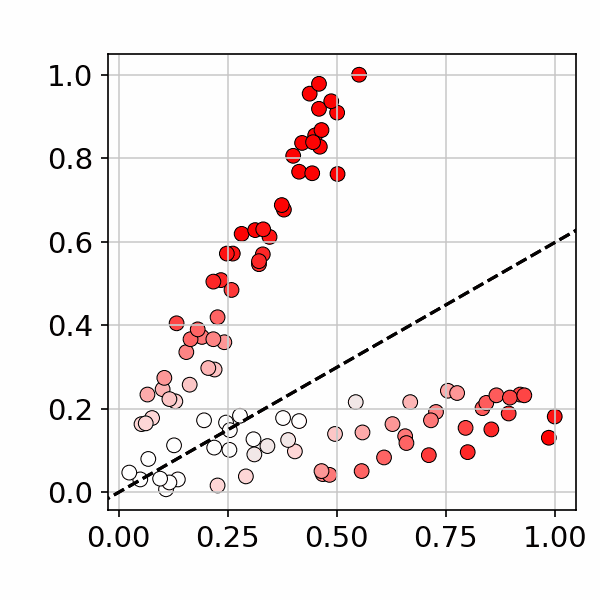

In [15]:
from IPython.display import Image
Image(open('optim.gif','rb').read())

If you look closely at the start of learning, both slopes seems to increase, but then one quickly change direction to go towards the rest of the points!

## Trying a higher learning rate

In [16]:
optimizer=optax.adam(1e-1)
a, _, _, _ = np.linalg.lstsq(xy[:,0].reshape(-1,1), xy[:,1].reshape(-1,1),rcond=None)
slopes = [a.ravel()[0],1/a.ravel()[0]]
with jax.default_device(jax.devices("cpu")[0]):
    opt_state = optimizer.init(slopes)
    all_slopes=[]
    all_slopes.append(slopes)
    objs=[]
    for epoch in range(200):
        obj, grads = jax.value_and_grad(loss_fun)(slopes)
        updates, opt_state = optimizer.update(grads, opt_state)
        slopes = optax.apply_updates(slopes, updates)
        all_slopes.append(slopes)
        objs.append(obj)
        if ((epoch+1) % 20 == 0):
            print(f'Epoch {epoch+1}, Objective: {obj.item()}')

Epoch 20, Objective: -7.298208236694336
Epoch 40, Objective: -19.881982803344727
Epoch 60, Objective: -20.228424072265625
Epoch 80, Objective: -20.4154109954834
Epoch 100, Objective: -20.414413452148438
Epoch 120, Objective: -20.4156436920166
Epoch 140, Objective: -20.4160099029541
Epoch 160, Objective: -20.416061401367188
Epoch 180, Objective: -20.41606903076172
Epoch 200, Objective: -20.41606903076172


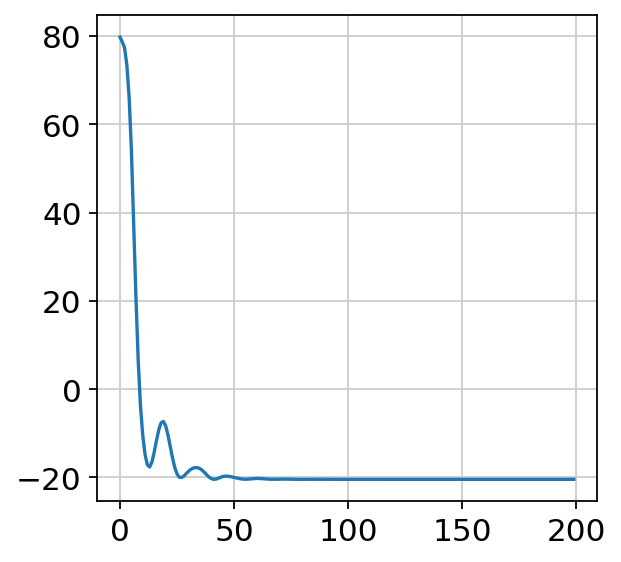

In [17]:
plt.plot(objs)

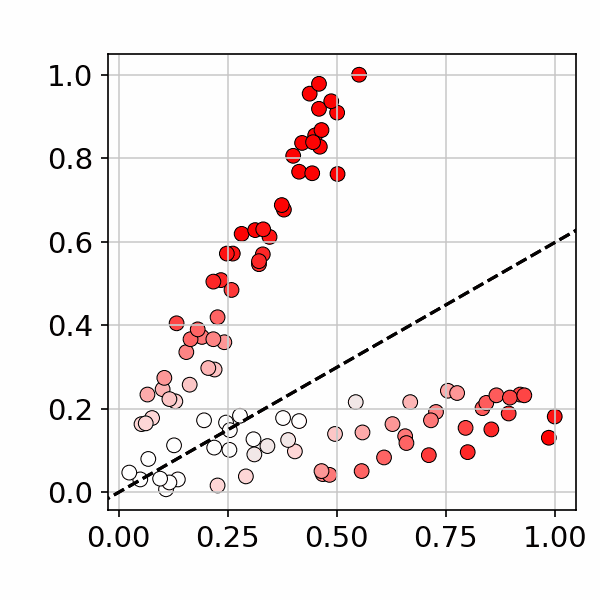

In [18]:
generate_gif(xy, all_slopes)
Image(open('optim.gif','rb').read())

Here is a good example of the flexibility (even spring-like!) of Adam optimizer: The large learning rate lead to an overshoot of the slope estimation, which is progressively dampened as the train progress, we even reach the global minima more rapidely!

## Estimating the performance of our model

Let's have a look at how good our model is in recovering the two initial groups of points:

In [19]:
f=1-get_assignment(xy,slopes)

In [20]:
from sklearn.metrics import roc_auc_score
print(f"AUC score: {roc_auc_score(group,f):.4f}")

AUC score: 0.9964


We are doing a very job at recovering the two underlying processes!